In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn

In [2]:
data_df = mavenn.load_example_dataset('sortseq')

In [3]:
data_df.head()

,y,ct,x
0,4,23.0,GGCTGTTCACTTTATGCTTCCGGCTTGTATTTTGTGTGC
1,2,12.0,GGTTTTACACATTATGCTTCCGGCTCGTCTCTTGTGTGG
2,1,11.0,GGCTTAACACTTAATGCTTCCGGCTCGTATGTTGTGTGG
3,5,10.0,GGTTTTACACTTTATGCTTCCCGCTCGTAAGGTGTGTCG
4,2,10.0,GGCTTTACACTTTATGCGTCCGGCTCGTATGTTGCGTGG


In [4]:
sequences = data_df['x'].values
bin_counts = data_df['y'].values
ct_n = data_df['ct'].values

In [5]:
NAR = mavenn.Model(regression_type='MPA',
                   x=sequences, 
                   y=bin_counts, 
                   ct_n = ct_n,
                   gpmap_type='additive',
                   alphabet='dna',
                   theta_regularization=0.001,
                   ohe_batch_size=50000)



In [6]:
NAR.get_nn().summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay [(None, 166)]        0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 156)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phi (Dense)                     (None, 1)            157         Sequence_only[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           100         phi[0][0]                        
_______________________________________________________________________________________

In [7]:
NAR.fit(epochs=20, 
        learning_rate=0.0005,
        early_stopping=True, 
        early_stopping_patience=5, 
        verbose=True)

Epoch 1/20
733/733 [==============================] - 1s 1ms/step - loss: 153.6076 - val_loss: 153.8069
Epoch 2/20
733/733 [==============================] - 1s 1ms/step - loss: 151.0486 - val_loss: 149.1184
Epoch 3/20
733/733 [==============================] - 1s 1ms/step - loss: 143.9109 - val_loss: 143.4313
Epoch 4/20
733/733 [==============================] - 1s 1ms/step - loss: 139.8368 - val_loss: 141.7351
Epoch 5/20
733/733 [==============================] - 1s 931us/step - loss: 138.6912 - val_loss: 141.2942
Epoch 6/20
733/733 [==============================] - 1s 944us/step - loss: 138.2558 - val_loss: 141.0966
Epoch 7/20
733/733 [==============================] - 1s 960us/step - loss: 138.0057 - val_loss: 140.8369
Epoch 8/20
733/733 [==============================] - 1s 953us/step - loss: 137.8588 - val_loss: 140.5451
Epoch 9/20
733/733 [==============================] - 1s 914us/step - loss: 137.7626 - val_loss: 140.4326
Epoch 10/20
733/733 [==============================] -

In [8]:
loss_history = NAR.model.history

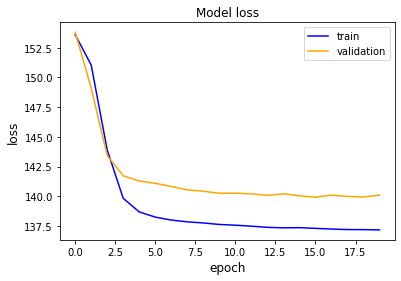

In [9]:
plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])
plt.show()

In [10]:
NAR.get_nn()

In [11]:
phi = NAR.x_to_phi(sequences)

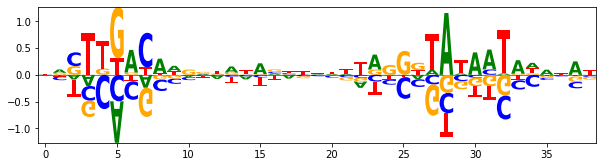

In [12]:
import logomaker
#theta_df = pd.DataFrame(NAR.get_nn().layers[2].get_weights()[0].reshape(39,4),columns=['A','C','G','T'])
theta_df = pd.DataFrame(NAR.get_gpmap_parameters()['value'].values[1:].reshape(39,4),columns=['A','C','G','T'])
logomaker.Logo(theta_df,center_values=False)

In [13]:
phi_range = np.linspace(min(phi),max(phi),1000)

In [14]:
p_of_all_y_given_phi = NAR.na_p_of_all_y_given_phi(phi_range)

[Text(0.5, 0, '-8.15'), Text(39.5, 0, '-2'), Text(78.5, 0, '3.288')]

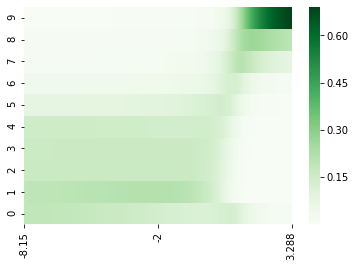

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
# if p_of_all_y_given_phi.T[p_of_all_y_given_phi.T.shape[0]-1][0]>p_of_all_y_given_phi.T[p_of_all_y_given_phi.T.shape[0]-1][p_of_all_y_given_phi.T.shape[1]-1]:
#     ax = sns.heatmap(pd.DataFrame(p_of_all_y_given_phi.T).loc[::1,::-1],cmap='Greens')
# else:
ax = sns.heatmap(p_of_all_y_given_phi.T,cmap='Greens')    
ax.invert_yaxis()
ax.set_xticks(([0,int(len(phi_range)/2),len(phi_range)-2]), minor=False)
middle_tick = str(phi_range[int(len(phi_range)/2)])
ax.set_xticklabels(([str(phi_range[0])[0:5],middle_tick[0:2],str(phi_range[len(phi_range)-1])[0:5]]), minor=False)

In [16]:
#NAR.save('sortseq_mpa_additive')